# CUNY 2019 poster: Entertaining ungrammatical structures can succeed where surprisal struggles
### Garrett Smith & Whitney Tabor
#### gasmith@uni-potsdam.de

In some theories of sentence processing, parsing is strictly controlled by a symbolic grammar. The highly successful surprisal theory (Hale, 2001; Levy, 2008; Smith and Levy, 2013) has been implemented as such a theory, using a probabilistic context-free grammar to define the space of possible structures (all perfectly grammatical). At each word, the parser distributes probability over possible structures given the input, and processing is more difficult if this probability distribution has to be updated a lot after processing a new word.

While surprisal theory has focused on comprehension, we apply it to a simple case of production, the verb selection task of Staub (2009): Subject noun phrases (NPs) are presented in rapid serial visual presentation (RSVP), followed by a two-alternative forced choice between a singular or plural verb form, followed by RSVP for the rest of the sentence. We can apply surprisal to this task by assuming the standard probability-updating mechanism for the RSVP parts of the sentence. For the verb choice, we assume that the parser first updates its probability distribution so that only singular and plural verbs have non-zero probability. Then, it samples a verb from that distribution and updates its probability distribution again to reflect the structural affordances available after choosing a verb form. The time it takes to produce the verb is then proportional to the sum of both of the updates. One consequence of this approach is that when the probability of singular and plural verbs is relatively evenly distributed (i.e., the distribution has high entropy), processing times should be slower. In such a case, whichever verb is sampled will incur a large processing cost. When the distribution has lower entropy, the parser will likely sample the highest-probability verb, so updating the probability distribution will usually incur a smaller cost and processing will be faster on average.

This is an intuitive prediction: when participants aren't as sure about which structure fits best, it takes them longer to respond.

The SOSP simulations here rely on the __[`sosp_simple`](https://github.com/garrett-m-smith/sosp_simple)__ package that I've put together.

In [1]:
# Importing and setting up
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # additional plotting tools
from sosp_simple import simple  # Assumes the sosp_simple package is installed

Here, we're simulating the competition between link attaching the N1 or the N2 to the verb's subject attachment site. The strength of each link gets its own dimension, so our system will be 2D. We enforce the rule that an attachment site can host one link, so our system will have attractors only where one (but not both) links are at full strength.

Setting up an SOSP simulation works like this: First, we map the feature/attachment link configurations to points in a high-dimensional space. Here, we're interested in the competition between a link that attaches the N1 to the verb's subject attachment site and a link that attaches the N2 to that site. Thus, we'll have two dimensions, each coding the strength of one of the links. The point $c_0 = (1, 0)$ will be the state when the system has attached the N1 to the verb, and $c_1 = (0, 1)$ is for the N2 attaching to the verb.

Each of these points is associated with harmony or well-formedness value $h_i$ (inspired by Smolensky, 1986, and calculated below). This is calculated as 1 minus the normalized Hamming distance (number of mismatching features) between the noun's features and the verb's subject attachment site features.

This only gives us a harmony value at discrete points in the state space. To get a harmony value for states of the system when one or both of the links are partially formed, we interpolate harmony values using radial basis functions, creating a harmony surface $H(\mathbf{x})$:
$$
H(\mathbf{x}) = h_0 \exp\left({-\frac{(\mathbf{x} - \mathbf{c_0})^2}{\gamma}}\right) + h_1 \exp\left({-\frac{(\mathbf{x} - \mathbf{c_1})^2}{\gamma}}\right)
$$

This creates a hilly harmony landscape. The $\gamma$ parameter sets the width of the hills. As long as it is less than approximately 0.4, the system functions well. Setting $\gamma = 0.2$ works well for our purposes, but feel free to play around with different values.

Parsing works by initializing the system at some point (we use $(0, 0)$) and having it try to maximize $H(\mathbf{x})$ by moving noisily uphill on the harmony landscape. The gradient ($\nabla$) is the vector derivative of a function and points uphill in the steepest direction, so the change in the system state in time $\mathbf{\dot{x}}$ is given by
$$
\mathbf{\dot{x}} = \nabla H(\mathbf{x}) + \sqrt{2D} \text{d}W
$$
where $D$ is the variance of the white noise process $\text{d}W$.

In [2]:
# Verb choice: settle on a noun-verb link -> number marking
centers = np.array([[1, 0], [0, 1.]]) # N1-V, N2-V
cond_names = ['container_long', 'collection_long', 'measure_long', 'quant_long',
              'container_short', 'collection_short', 'measure_short', 'quant_short']
gamma = 0.2

## Features

These features are based on empirical evidence presented in Smith, Franck, & Tabor (2018, *Cog. Sci. 42*(S4)). They are: $\pm$ noun, $\pm$ container, $\pm$ spatial configuration of N2s implied, $\pm$ prohibition against abstract N2s, $\pm$ present in the input

| Word | Noun | container | spatial config. | prohib. abstract N2 | present |
| - | - | - | - | - | - |
| Container | 1 | 1 | 1 | 1 | 1 |
| Collection | 1 | 0 | 1 | 1 | 1 |
| Measure | 1 | 0 | 0 | 0 | 1 |
| Quant | 0 | 0 | 0 | 0 | 1 |
| N2 | 1 | 1 | 1 | 0 (1) | 1/0 |
| **Verb's subject attch. site** | 1 | 1 | 1 | 1 | 1 |

We get a better fit to the data if the N2 is not a perfect feature match for the verb's subject attachment site. Setting the N2's abstract-N2 feature to 0 does so. This both makes intuitive sense and is justified if we assume that reading the N1 leads the parse to expect verbs that like subjects that don't allow abstract N2s.

Since we are considering five features here, missing one of the features decrements the harmony by 0.2, one fifth of its maximum of 1.0.

In [3]:
fm = 0.2  # cost per feature mismatch
# Making N2 not quite perfect; excellent fit to the data
cond_harmonies = np.array([[1, 1-fm],
                           [1-fm, 1-fm],
                           [1-fm*3, 1-fm],
                           [1-fm*4, 1-fm],
                           [1, 1-fm*2],
                           [1-fm, 1-fm*2],
                           [1-fm*3, 1-fm*2],
                           [1-fm*4, 1-fm*2]])

# Making N2 a perfect match all the time; good, but not great fit to data
#cond_harmonies = np.array([[1, 1],
#                           [1-fm, 1],
#                           [1-fm*3, 1],
#                           [1-fm*4, 1],
#                           [1, 1-fm],
#                           [1-fm, 1-fm],
#                           [1-fm*3, 1-fm],
#                           [1-fm*4, 1-fm]])

cond_harmonies

array([[1. , 0.8],
       [0.8, 0.8],
       [0.4, 0.8],
       [0.2, 0.8],
       [1. , 0.6],
       [0.8, 0.6],
       [0.4, 0.6],
       [0.2, 0.6]])

The next cell sets up the simple SOSP model using the Chebyshev stopping criterion---the system stops processing once it gets within a small distance to one of the attractors one at least one dimension---sets the noise level, and finds the exact location in state space of the attractors. (Due to the mathematical form of SOSP's equations, the attractors are typically a very small distance away from the corners of the unit hypercube, not directly at the corners.)

In [4]:
xinit = np.zeros(centers.shape[1])
sys = simple.SimpleModel(centers=centers, local_harmonies=np.array([0, 0]),
                         stopping_crit='cheb_stop')
sys.set_gamma(gamma)
sys.set_noise_mag(0.0005)
sys.locate_attrs()

Found 2 unique attractors from 2 centers


The next cell demonstrates an important feature of SOSP: When the harmony of a structure is sufficiently low, it is no longer an attractor of SOSP's dynamics. That is, the system will never settle on that structure. We see that in the fourth condition, +N2 Quantifiers (e.g., *many apples is/are*). The structure where the quantifier (acting as if it were N1) attaches directly as the subject of the verb has such low harmony (0.2) that it is no longer an attractor. This means that the system will always build the N2-headed structure. The non-stable structure can still affect processing, though, by warping the harmony landscape and slowing processing if the system gets close to where the ghost attractor would have been (Smith & Tabor, 2018, ICCM; Strogatz, 1994, pp. 98--101).

In [5]:
for c in range(cond_harmonies.shape[0]):
    sys.set_local_harmonies(cond_harmonies[c,])
    sys.locate_attrs()

Found 2 unique attractors from 2 centers
Found 2 unique attractors from 2 centers
Found 2 unique attractors from 2 centers
Found 1 unique attractors from 2 centers
Found 2 unique attractors from 2 centers
Found 2 unique attractors from 2 centers
Found 2 unique attractors from 2 centers
Found 1 unique attractors from 2 centers


Now, we actually run the simulations. The pattern is already very clear with only 100 simulations per condition.

In [6]:
data = sys.run_multiple_conditions(n_runs=100, conditions=cond_harmonies)

Found 2 unique attractors from 2 centers
Condition 0
Run number:
[0] Found 2 unique attractors from 2 centers
Condition 1
Run number:
[0] Found 2 unique attractors from 2 centers
Condition 2
Run number:
[0] Found 1 unique attractors from 2 centers
Condition 3
Run number:
[0] Found 2 unique attractors from 2 centers
Condition 4
Run number:
[0] Found 2 unique attractors from 2 centers
Condition 5
Run number:
[0] Found 2 unique attractors from 2 centers
Condition 6
Run number:
[0] Found 1 unique attractors from 2 centers
Condition 7
Run number:
[0] 

In [7]:
# Setting up for printing results and plotting
cond_dict = {i: n for i, n in zip(range(len(cond_names)), cond_names)}
data['Condition'] = data.Condition.map(cond_dict)
print(data.groupby(['Condition', 'CenterNr']).agg(['mean', 'std', 'count']))
print(data.groupby(['Condition']).Time.agg(['mean', 'std']))

                                 Time                 
                                 mean        std count
Condition        CenterNr                             
collection_long  0         260.708333  39.268827    48
                 1         269.384615  42.265340    52
collection_short 0         275.649351  42.031870    77
                 1         341.652174  44.896455    23
container_long   0         228.695122  38.939234    82
                 1         260.111111  57.768187    18
container_short  0         229.521739  38.831696    92
                 1         311.250000  52.458827     8
measure_long     0         372.000000  18.384776     2
                 1         286.857143  65.385770    98
measure_short    0         474.750000  72.235231     8
                 1         391.717391  84.675506    92
quant_long       1         275.100000  49.687203   100
quant_short      0         999.000000   0.000000     2
                 1         379.051020  93.325654    98
          

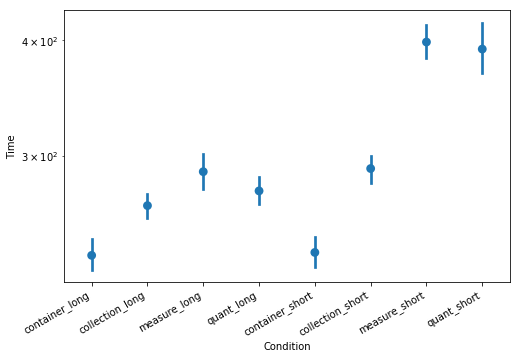

In [8]:
# Not an especially informative plot...
plt.subplots(figsize=(8, 5))
fig = sns.pointplot(x='Condition', y='Time', data=data, ci=95, linestyles='')
fig.set_xticklabels(fig.get_xticklabels(), rotation=30, ha='right')
fig.set_yscale('log')
plt.show()

In [9]:
# These functions split up the conditions in the data set. Book keeping...
def split_short(row):
    if 'short' in row['Condition']:
        return '-N2'
    elif 'long' in row['Condition']:
        return '+N2'


def split_n1(row):
    if 'cont' in row['Condition']:
        return 'Cont.'
    elif 'coll' in row['Condition']:
        return 'Coll.'
    elif 'meas' in row['Condition']:
        return 'Meas.'
    elif 'quant' in row['Condition']:
        return 'Quant.'

In [10]:
data['N2Presence'] = data.apply(lambda row: split_short(row), axis=1)
data['N1Type'] = data.apply(lambda row: split_n1(row), axis=1)

In [11]:
data.head()

,CenterNr,Time,Condition,N2Presence,N1Type
0,0,248,container_long,+N2,Cont.
0,0,216,container_long,+N2,Cont.
0,0,213,container_long,+N2,Cont.
0,0,238,container_long,+N2,Cont.
0,0,187,container_long,+N2,Cont.


<Figure size 432x288 with 0 Axes>

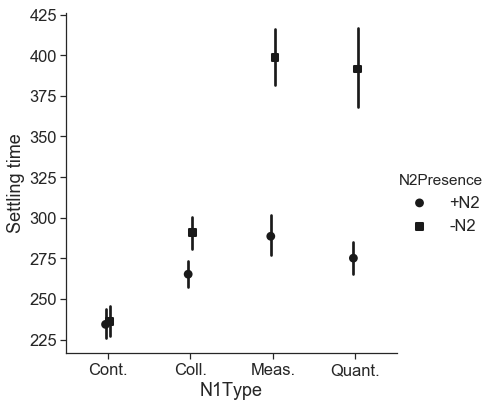

In [20]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
sns.despine()
g = sns.catplot(x="N1Type", y="Time", hue="N2Presence", data=data, kind="point", linestyles='', dodge=True,
                   height=6, legend_out=True, markers=['o', 's'], palette={"+N2": "k", "-N2": "k"})
plt.ylabel('Settling time')
plt.show()

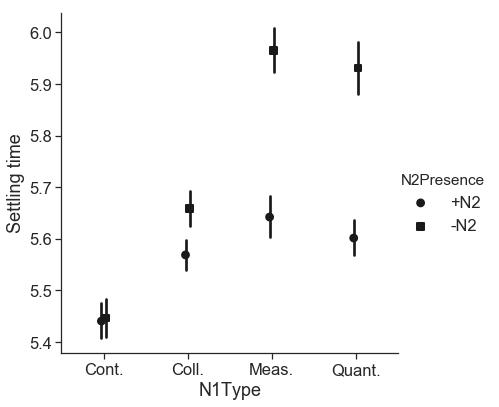

In [19]:
# Log scaled settling times
data['LogTime'] = np.log(data['Time'])
g = sns.catplot(x="N1Type", y="LogTime", hue="N2Presence", data=data, kind="point", linestyles='', dodge=True,
                   height=6, legend_out=True, markers=['o', 's'], palette={"+N2": "k", "-N2": "k"})
plt.ylabel('Settling time')
plt.show()

In [13]:
# Uncomment to save the figure
#g.savefig('PsPartSimpleRTs02.pdf')

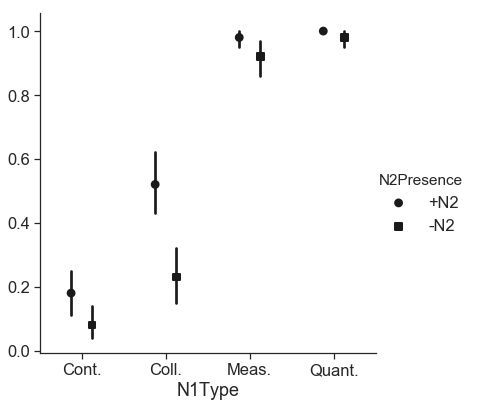

In [22]:
g2 = sns.catplot(x="N1Type", y="CenterNr", hue="N2Presence", data=data, kind="point", linestyles='',
                    dodge=0.25, height=6, markers=['o', 's'], palette={"+N2": "k", "-N2": "k"}, legend_out=True)
#plt.legend(loc='right')
plt.ylabel('')
plt.show()

In [15]:
# Uncomment to save the figure
#g2.savefig('PsPartSimpleProps02.pdf')

The next few cells produce the figures shown in the CUNY abstract and poster.

In [23]:
# Calculating the entropy of the models parse selection distribution
import pandas as pd
def entr_fn(x):
    pr = sum(x) / len(x)
    S = -pr*np.log(pr) - (1-pr)*np.log(1-pr)
    if not np.isnan(S):
        return S
    else:
        return 0.0
entr = pd.DataFrame(data.copy().groupby(['N1Type', 'N2Presence']).CenterNr.agg(entr_fn)).reset_index()
#print(entr)
entr[(entr['N1Type']=='Coll.') & (entr['N2Presence']=='+N2')]
data['Entropy'] = 0
data.head()
for n in ['Cont.', 'Coll.', 'Meas.', 'Quant.']:
    for l in ['+N2', '-N2']:
        d = entr.loc[(entr['N1Type']==n) & (entr['N2Presence']==l),:].values.flatten()[-1]
        data.loc[(data['N1Type']==n) & (data['N2Presence']==l), 'Entropy'] = d
data.head()

/Users/garrettsmith/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/Users/garrettsmith/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


,CenterNr,Time,Condition,N2Presence,N1Type,LogTime,Entropy
0,0,248,container_long,+N2,Cont.,5.513429,0.471393
0,0,216,container_long,+N2,Cont.,5.375278,0.471393
0,0,213,container_long,+N2,Cont.,5.361292,0.471393
0,0,238,container_long,+N2,Cont.,5.472271,0.471393
0,0,187,container_long,+N2,Cont.,5.231109,0.471393


In [24]:
entr

,N1Type,N2Presence,CenterNr
0,Coll.,+N2,0.692347
1,Coll.,-N2,0.539276
2,Cont.,+N2,0.471393
3,Cont.,-N2,0.278769
4,Meas.,+N2,0.098039
5,Meas.,-N2,0.278769
6,Quant.,+N2,0.000000
7,Quant.,-N2,0.098039


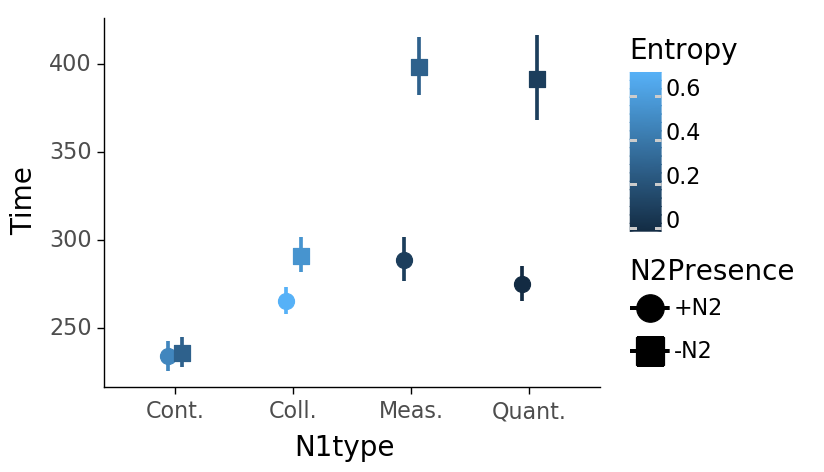

<ggplot: (302558184)>

In [25]:
# Basically a port of ggplot2 in R for Python
from plotnine import *
from pandas.api.types import CategoricalDtype
n1typelist = ['Cont.', 'Coll.', 'Meas.', 'Quant.']
n1_cat = CategoricalDtype(categories=n1typelist, ordered=True)
data['N1type'] = data['N1Type'].astype(str).astype(n1_cat)

g = ggplot(data, aes(x = 'N1type', y = 'Time', shape='N2Presence', color='Entropy')) +\
stat_summary(size=1.5, position=position_dodge(width=0.25)) + scale_color_gradient() +\
scale_shape_manual(values=('o', 's')) +\
theme_classic(base_size = 20)
g

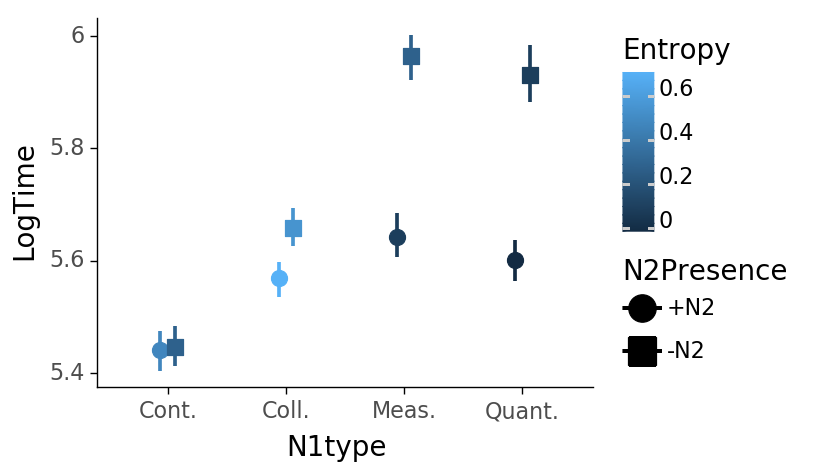

<ggplot: (302823446)>

In [27]:
# Log scale
g = ggplot(data, aes(x = 'N1type', y = 'LogTime', shape='N2Presence', color='Entropy')) +\
stat_summary(size=1.5, position=position_dodge(width=0.25)) + scale_color_gradient() +\
scale_shape_manual(values=('o', 's')) +\
theme_classic(base_size = 20)
g

In [19]:
# Uncomment to save
#g.save(filename='PsPartModRT.pdf',
#       path='/Users/garrettsmith/Google Drive/UConn/Research/Dissertation/DissertationDefense/Figures',
#       width=8, height=8, units='in')

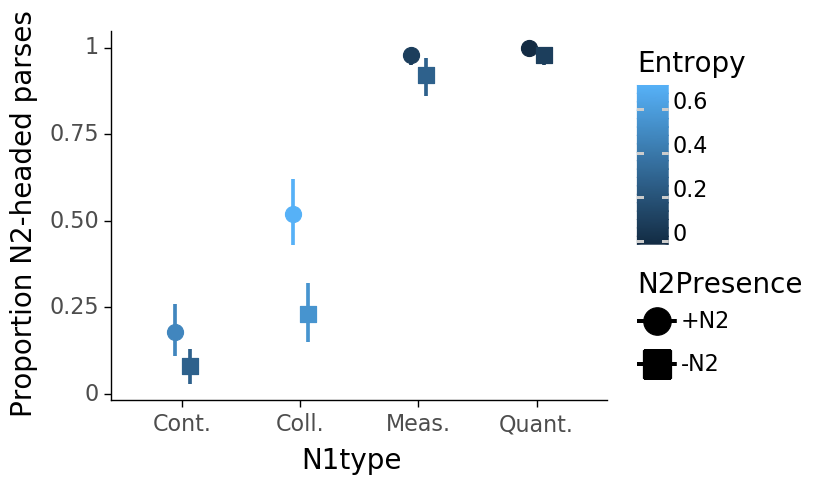

<ggplot: (-9223372036553053629)>

In [26]:
g2 = ggplot(data, aes(x = 'N1type', y = 'CenterNr', shape='N2Presence', color='Entropy')) +\
stat_summary(size=1.5, position=position_dodge(width=0.25)) + scale_color_gradient() +\
scale_shape_manual(values=('o', 's')) +\
labs(y='Proportion N2-headed parses') + theme_classic(base_size = 20)
g2

In [ ]:
# Uncomment to save
#g2.save(filename='PsPartModProps.pdf',
#       path='/Users/garrettsmith/Google Drive/UConn/Research/Dissertation/DissertationDefense/Figures',
#       width=8, height=8, units='in')

Recall surprisal's prediction: Higher entropy verb choice distributions should be associated with slower faster processing times. In the human data, this was not the case, and it's not the case here in the model data. That's because SOSP says that processing times are proportional to the harmony of the structure that gets built (Smith & Tabor, 2018, ICCM). More well-formed structures are faster to build than more ill-formed structures. The SOSP model here rarely builds anything other than the N2-headed structure in Measure Phrases and Quantifiers (where surprisal is most off), but it still processes the structures slowly on average because the structure it builds is not great: The N2 is never a perfect feature match for the verb's subject attachment site, and it is especially bad when it is elided. But since there's no real competition from the N1-headed structure, SOSP has no choice but to slowly build the low-harmony, N2-headed structure.